# Benchmark: Area computation

Benchmark comparing area computation across:

* [georust/geo](https://lib.rs/crates/geo) crate
* The [geos C library](https://trac.osgeo.org/geos/), used through high-level Rust bindings via the [geos](https://lib.rs/crates/geos) crate

## Benchmarked operation

Each iteration computes the area of the multi-polygon representing all distrcits of India.

# Prerequisites

Generate data:

```sh
cd harness
cargo run --release --bin benchmark_area -- --out-file ../analysis/benchmark_area/data.json --geojson-file ../data/india_districts/polbnda_ind.geojson --iterations 1000
```

### Loading data from /mnt/data/source/explore-georust/analysis/benchmark_area/data.json
### Statistics: Raw data
        duration.total_ms             
program               geo         geos
count         1000.000000  1000.000000
mean           167.243513   389.750006
std             67.928483   131.412703
min             93.380255   214.057707
25%             97.341188   224.539315
50%            220.763785   469.510183
75%            223.491768   475.610704
max            459.322104  1026.297717


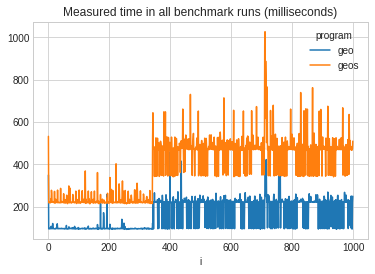

### Statistics: After outlier removal
        duration.total_ms            
program               geo        geos
count          971.000000  971.000000
mean           165.709290  381.138436
std             64.929681  120.859106
min             93.380255  214.057707
25%             97.331030  224.044657
50%            220.707478  469.190504
75%            223.388955  474.856121
max            270.976625  652.335735


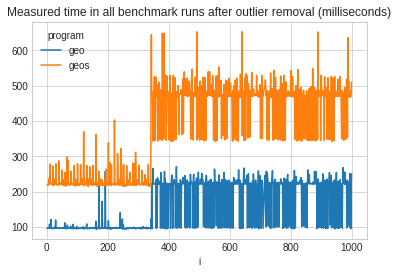

## Absolute difference in runtimes compared to geo
        difference_ms
program          geos
count      971.000000
mean       215.429145
std         92.341647
min        -16.482806
25%        124.095211
50%        238.493549
75%        260.666081
max        554.554351


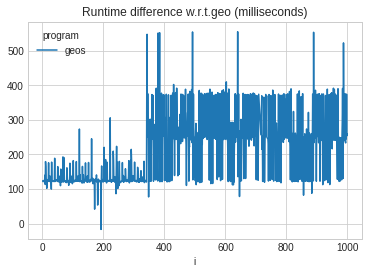

## Relative difference (percent) in runtimes compared to geo
        relative_difference_percent
program                        geos
count                    971.000000
mean                     150.158775
std                       98.555771
min                       -6.401795
25%                      110.090713
50%                      123.272827
75%                      131.749228
max                      573.826373


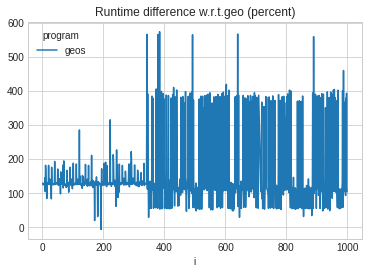

In [1]:
import os
data_absolute_path = os.path.join(os.getcwd(), 'data.json')
%run ../common/benchmark_analysis.ipynb